In [27]:
import os
import yaml
import cv2
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO
from IPython.display import Image, display
from pathlib import Path

In [28]:
DATASET_PATH = "constellation_dataset"

In [29]:
def explore_dataset(dataset_path):
    """Function to explore the YOLOv8 format dataset structure"""
    print(f"Exploring dataset at: {dataset_path}")
    
    # Check if the path exists
    if not os.path.exists(dataset_path):
        print(f"Error: Path {dataset_path} does not exist")
        return
    
    # Check for data.yaml file
    yaml_path = os.path.join(dataset_path, "data.yaml")
    if os.path.exists(yaml_path):
        print(f"Found data.yaml at {yaml_path}")
        with open(yaml_path, 'r') as f:
            data_config = yaml.safe_load(f)
            print("\nData Config:")
            print(f"- Train path: {data_config.get('train')}")
            print(f"- Val path: {data_config.get('valid')}")
            print(f"- Test path: {data_config.get('test')}")
            print(f"- Number of classes: {data_config.get('nc')}")
            print(f"- Classes: {data_config.get('names')}")
    else:
        print(f"Warning: data.yaml not found at {yaml_path}")

    for split in ["train", "valid", "test"]:
        split_dir = os.path.join(dataset_path, split)
        if os.path.exists(split_dir):
            images_dir = os.path.join(split_dir, "images")
            labels_dir = os.path.join(split_dir, "labels")
            
            if os.path.exists(images_dir) and os.path.exists(labels_dir):
                image_count = len([f for f in os.listdir(images_dir) if f.endswith(('.jpg', '.jpeg', '.png'))])
                label_count = len([f for f in os.listdir(labels_dir) if f.endswith('.txt')])
                print(f"\n{split.capitalize()} set:")
                print(f"- Images: {image_count}")
                print(f"- Labels: {label_count}")
                
                if image_count > 0:
                    # Show example image
                    sample_image = os.path.join(images_dir, os.listdir(images_dir)[0])
                    print(f"- Sample image: {sample_image}")
            else:
                print(f"\n{split.capitalize()} set: Missing images or labels directory")
        else:
            print(f"\n{split.capitalize()} set: Directory not found")

In [30]:
explore_dataset(DATASET_PATH)

Exploring dataset at: constellation_dataset
Found data.yaml at constellation_dataset\data.yaml

Data Config:
- Train path: ../train/images
- Val path: None
- Test path: ../test/images
- Number of classes: 12
- Classes: ['Aquarius', 'Aries', 'Cancer', 'Capricornus', 'Gemini', 'Leo', 'Libra', 'Pisces', 'Sagittarius', 'Scorpius', 'Taurus', 'Virgo']

Train set:
- Images: 449
- Labels: 449
- Sample image: constellation_dataset\train\images\Aquarius_eight_180-_jpg.rf.1bcac1ae0f2fc78a675e3b198ad80241.jpg

Valid set:
- Images: 128
- Labels: 128
- Sample image: constellation_dataset\valid\images\Aquarius_fifth_120-_jpg.rf.0787d27723e4e4f3eb233f6b995732fe.jpg

Test set:
- Images: 65
- Labels: 65
- Sample image: constellation_dataset\test\images\Aquarius_eight_120-_jpg.rf.907a0067cd1eb10f548157c3f6d632cc.jpg


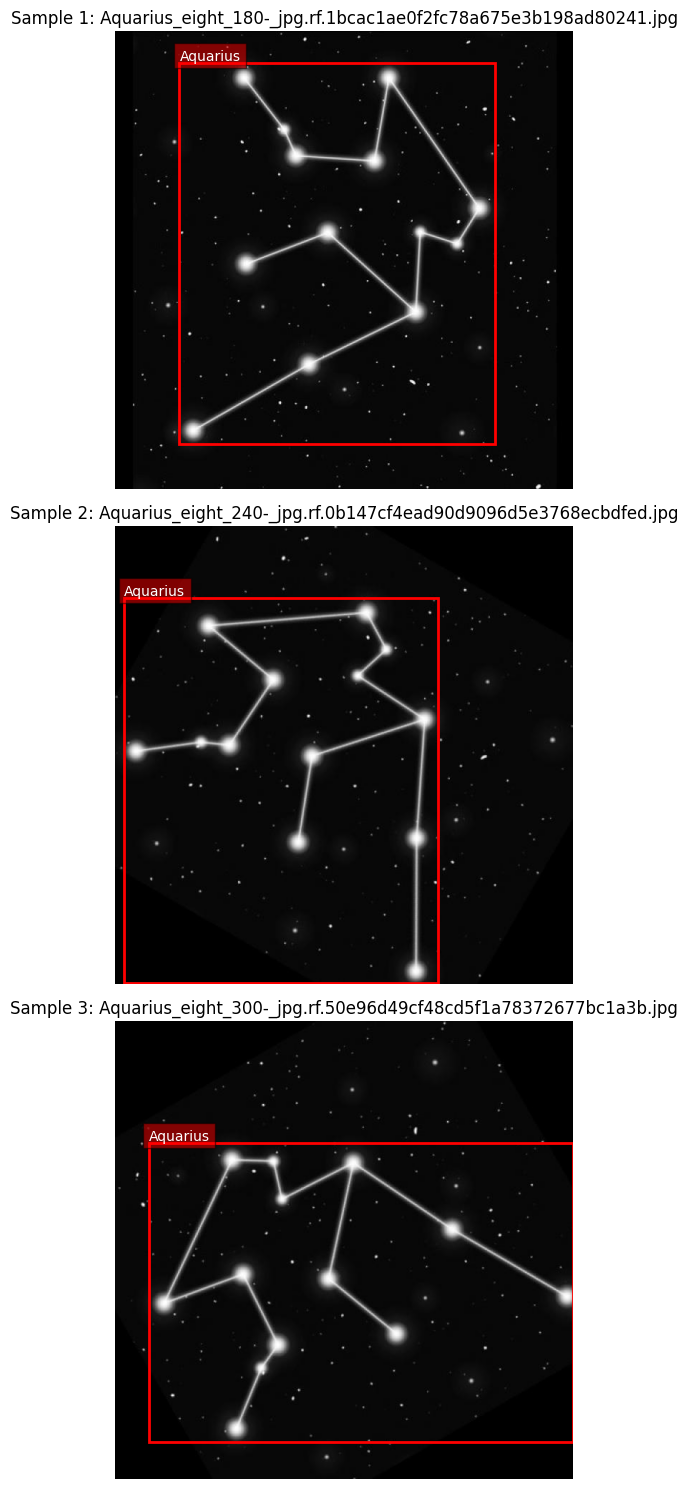

In [31]:
def visualize_samples(dataset_path, num_samples=3):
    """Visualize sample images with their annotations"""
    train_images_dir = os.path.join(dataset_path, "train", "images")
    train_labels_dir = os.path.join(dataset_path, "train", "labels")
    
    # Load class names from data.yaml
    yaml_path = os.path.join(dataset_path, "data.yaml")
    with open(yaml_path, 'r') as f:
        data_config = yaml.safe_load(f)
    class_names = data_config.get('names')
    
    # Get a list of image files
    image_files = [f for f in os.listdir(train_images_dir) if f.endswith(('.jpg'))]
    
    # Select sample images (either randomly or first few)
    samples = image_files[:num_samples]
    
    plt.figure(figsize=(15, 5 * num_samples))
    
    for i, sample in enumerate(samples):
        # Load image and get dimensions
        img_path = os.path.join(train_images_dir, sample)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        height, width, _ = img.shape
        
        # Load corresponding label file
        label_file = os.path.splitext(sample)[0] + '.txt'
        label_path = os.path.join(train_labels_dir, label_file)
        
        plt.subplot(num_samples, 1, i+1)
        plt.imshow(img)
        
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                lines = f.readlines()
                
            for line in lines:
                parts = line.strip().split()
                class_id, x_center, y_center, w, h = map(float, parts)
                class_id = int(class_id)
                
                # Convert normalized coordinates to pixel values
                x_center, y_center = x_center * width, y_center * height
                w, h = w * width, h * height
                
                # Calculate bounding box coordinates
                x1 = int(x_center - w/2)
                y1 = int(y_center - h/2)
                x2 = int(x_center + w/2)
                y2 = int(y_center + h/2)
                
                # Draw bounding box
                rect = plt.Rectangle((x1, y1), x2-x1, y2-y1, fill=False, edgecolor='red', linewidth=2)
                plt.gca().add_patch(rect)
                
                # Add class label
                class_name = class_names[class_id] if class_id < len(class_names) else f"Class {class_id}"
                plt.text(x1, y1-5, class_name, color='white', fontsize=10, 
                         bbox=dict(facecolor='red', alpha=0.5))
        
        plt.title(f"Sample {i+1}: {sample}")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

    # Visualize sample training images with annotations
try:
    visualize_samples(DATASET_PATH)
except Exception as e:
    print(f"Error visualizing samples: {e}")

In [32]:
def enhance_star_visibility(image):
    """
    Enhance star visibility in constellation images using multiple techniques
    
    Args:
        image: Input image (BGR format from cv2.imread)
    
    Returns:
        Enhanced image
    """
    # Convert to grayscale for some processing
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # 1. Contrast Limited Adaptive Histogram Equalization (CLAHE)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    clahe_img = clahe.apply(gray)
    
    # 2. Increase contrast using gamma correction
    gamma = 0.7  # Values < 1 will enhance bright regions (stars)
    gamma_corrected = np.array(255 * (clahe_img / 255) ** gamma, dtype=np.uint8)
    
    # 3. Apply slight Gaussian blur to reduce noise
    blurred = cv2.GaussianBlur(gamma_corrected, (3, 3), 0)
    
    # 4. Apply sharpening filter to enhance stars
    kernel = np.array([[-1, -1, -1],
                       [-1,  9, -1],
                       [-1, -1, -1]])
    sharpened = cv2.filter2D(blurred, -1, kernel)
    
    # 5. Apply threshold to further enhance bright spots (stars)
    _, thresh = cv2.threshold(sharpened, 150, 255, cv2.THRESH_TOZERO)
    
    # Convert back to color for visualization
    enhanced = cv2.cvtColor(thresh, cv2.COLOR_GRAY2BGR)
    
    return enhanced

Visualizing sample images with star visibility enhancement:


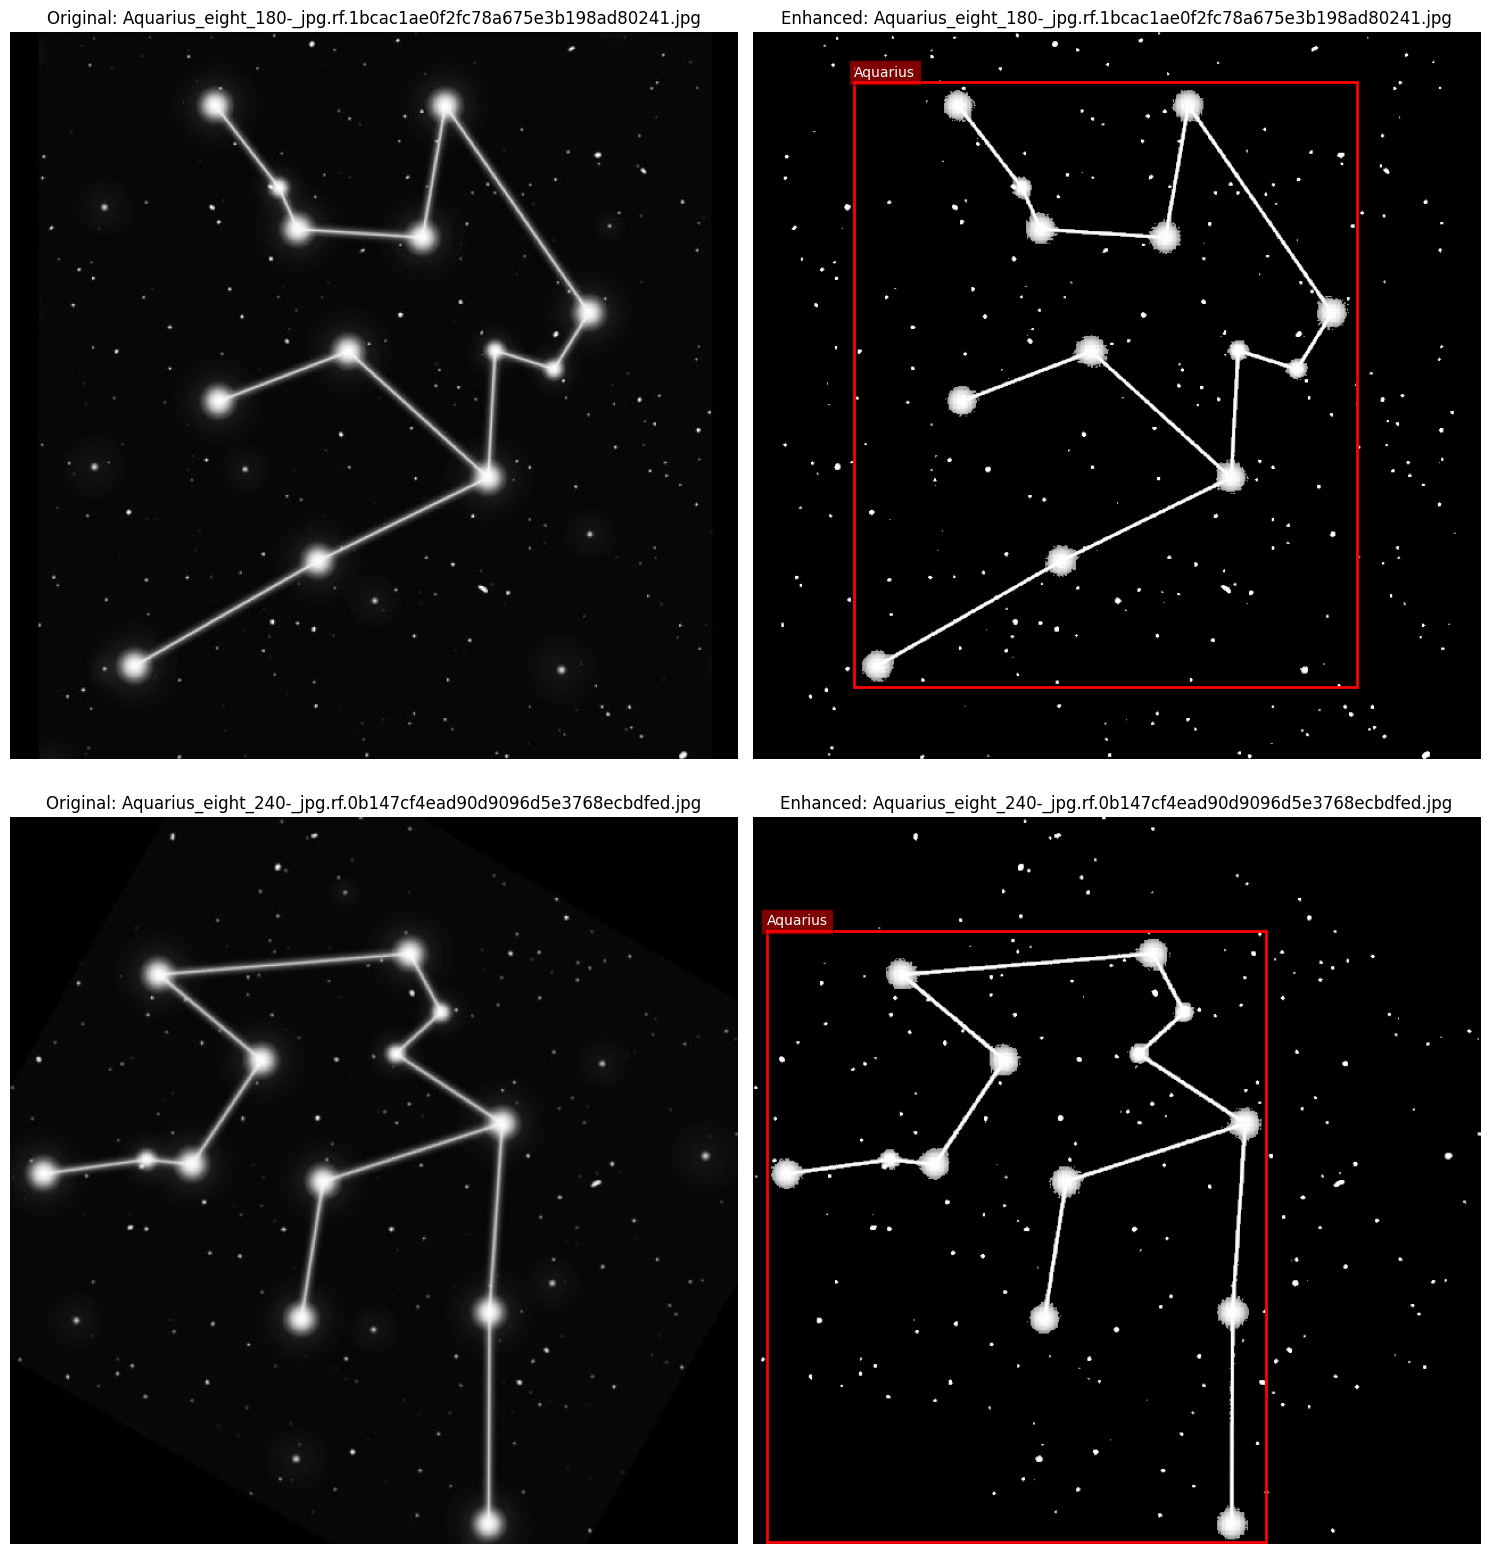

In [33]:
def visualize_samples(dataset_path, num_samples=3, apply_enhancement=True):
    """Visualize sample images with their annotations and optional enhancement"""
    train_images_dir = os.path.join(dataset_path, "train", "images")
    train_labels_dir = os.path.join(dataset_path, "train", "labels")
    
    # Load class names from data.yaml
    yaml_path = os.path.join(dataset_path, "data.yaml")
    with open(yaml_path, 'r') as f:
        data_config = yaml.safe_load(f)
    class_names = data_config.get('names')
    
    # Get a list of image files
    image_files = [f for f in os.listdir(train_images_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]
    
    # Select sample images (either randomly or first few)
    samples = image_files[:num_samples]
    
    plt.figure(figsize=(15, 8 * num_samples))
    
    for i, sample in enumerate(samples):
        # Load image and get dimensions
        img_path = os.path.join(train_images_dir, sample)
        img = cv2.imread(img_path)
        height, width, _ = img.shape
        
        # Create enhanced version if requested
        if apply_enhancement:
            enhanced_img = enhance_star_visibility(img)
            
            # Display original image
            plt.subplot(num_samples, 2, i*2+1)
            plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
            plt.title(f"Original: {sample}")
            plt.axis('off')
            
            # Display enhanced image
            plt.subplot(num_samples, 2, i*2+2)
            plt.imshow(cv2.cvtColor(enhanced_img, cv2.COLOR_BGR2RGB))
            plt.title(f"Enhanced: {sample}")
            plt.axis('off')
            
            # Use enhanced image for annotation
            img_display = enhanced_img.copy()
        else:
            plt.subplot(num_samples, 1, i+1)
            img_display = img.copy()
            plt.imshow(cv2.cvtColor(img_display, cv2.COLOR_BGR2RGB))
            plt.title(f"Sample {i+1}: {sample}")
            plt.axis('off')
        
        # Load corresponding label file
        label_file = os.path.splitext(sample)[0] + '.txt'
        label_path = os.path.join(train_labels_dir, label_file)
        
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                lines = f.readlines()
                
            for line in lines:
                parts = line.strip().split()
                class_id, x_center, y_center, w, h = map(float, parts)
                class_id = int(class_id)
                
                # Convert normalized coordinates to pixel values
                x_center, y_center = x_center * width, y_center * height
                w, h = w * width, h * height
                
                # Calculate bounding box coordinates
                x1 = int(x_center - w/2)
                y1 = int(y_center - h/2)
                x2 = int(x_center + w/2)
                y2 = int(y_center + h/2)
                
                # Draw bounding box on appropriate subplot
                if apply_enhancement:
                    rect = plt.Rectangle((x1, y1), x2-x1, y2-y1, fill=False, edgecolor='red', linewidth=2)
                    plt.subplot(num_samples, 2, i*2+2).add_patch(rect)
                    
                    # Add class label
                    class_name = class_names[class_id] if class_id < len(class_names) else f"Class {class_id}"
                    plt.subplot(num_samples, 2, i*2+2).text(x1, y1-5, class_name, color='white', fontsize=10, 
                                bbox=dict(facecolor='red', alpha=0.5))
                else:
                    rect = plt.Rectangle((x1, y1), x2-x1, y2-y1, fill=False, edgecolor='red', linewidth=2)
                    plt.gca().add_patch(rect)
                    
                    # Add class label
                    class_name = class_names[class_id] if class_id < len(class_names) else f"Class {class_id}"
                    plt.text(x1, y1-5, class_name, color='white', fontsize=10, 
                             bbox=dict(facecolor='red', alpha=0.5))
    
    plt.tight_layout()
    plt.show()

# Visualize sample training images with annotations and enhancements
try:
    print("Visualizing sample images with star visibility enhancement:")
    visualize_samples(DATASET_PATH, num_samples=2, apply_enhancement=True)
except Exception as e:
    print(f"Error visualizing samples: {e}")

In [34]:
def advanced_star_enhancement(image, star_threshold=150, enhance_contrast=True, enhance_stars=True, reduce_noise=True):
    """
    Advanced function to enhance star visibility in constellation images with multiple techniques
    and parameter control
    
    Args:
        image: Input image (BGR format from cv2.imread)
        star_threshold: Threshold value for star detection (0-255)
        enhance_contrast: Whether to apply contrast enhancement
        enhance_stars: Whether to apply star enhancement filters
        reduce_noise: Whether to apply noise reduction
    
    Returns:
        Enhanced image
    """
    # Make a copy of the original image
    enhanced = image.copy()
    
    # Convert to grayscale for processing
    gray = cv2.cvtColor(enhanced, cv2.COLOR_BGR2GRAY)
    
    if reduce_noise:
        # Apply bilateral filter to reduce noise while preserving edges
        # This is better than Gaussian blur for preserving star edges
        gray = cv2.bilateralFilter(gray, 5, 50, 50)
    
    if enhance_contrast:
        # Apply CLAHE (Contrast Limited Adaptive Histogram Equalization)
        clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
        gray = clahe.apply(gray)
        
        # Apply gamma correction to enhance bright regions (stars)
        gamma = 0.5  # Lower gamma value = more enhancement of bright spots
        gray = np.array(255 * (gray / 255) ** gamma, dtype=np.uint8)
    
    if enhance_stars:
        # Apply unsharp mask for local contrast enhancement
        gaussian = cv2.GaussianBlur(gray, (0, 0), 3.0)
        unsharp_mask = cv2.addWeighted(gray, 2.0, gaussian, -1.0, 0)
        gray = unsharp_mask
        
        # Apply morphological operations to enhance stars
        # Create a kernel for morphology operations
        kernel = np.ones((2, 2), np.uint8)
        
        # Apply white top-hat transform to enhance small bright details
        tophat = cv2.morphologyEx(gray, cv2.MORPH_TOPHAT, kernel)
        gray = cv2.add(gray, tophat)
    
    # Apply thresholding to isolate stars
    _, stars_mask = cv2.threshold(gray, star_threshold, 255, cv2.THRESH_TOZERO)
    
    # Create color star layer for blending
    star_layer = cv2.cvtColor(stars_mask, cv2.COLOR_GRAY2BGR)
    
    # Create a blended output with original colors but enhanced stars
    # Convert original to HSV for better color handling
    original_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(original_hsv)
    
    # Replace V (brightness) with our enhanced stars
    v = cv2.bitwise_or(v, stars_mask)
    
    # Merge channels back together
    enhanced_hsv = cv2.merge([h, s, v])
    enhanced = cv2.cvtColor(enhanced_hsv, cv2.COLOR_HSV2BGR)
    
    # Apply slight sharpening for final touch
    kernel = np.array([[-1, -1, -1],
                       [-1,  9, -1],
                       [-1, -1, -1]])
    enhanced = cv2.filter2D(enhanced, -1, kernel)
    
    return enhanced

In [35]:
def visualize_enhanced_samples(dataset_path, num_samples=3, enhancement_methods=['original', 'basic', 'advanced']):
    """Visualize sample images with different enhancement techniques"""
    train_images_dir = os.path.join(dataset_path, "train", "images")
    train_labels_dir = os.path.join(dataset_path, "train", "labels")
    
    # Load class names from data.yaml
    yaml_path = os.path.join(dataset_path, "data.yaml")
    with open(yaml_path, 'r') as f:
        data_config = yaml.safe_load(f)
    class_names = data_config.get('names')
    
    # Get a list of image files
    image_files = [f for f in os.listdir(train_images_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]
    
    # Select sample images
    samples = image_files[:num_samples]
    
    # Calculate number of columns based on enhancement methods
    num_methods = len(enhancement_methods)
    
    plt.figure(figsize=(5*num_methods, 5*num_samples))
    
    for i, sample in enumerate(samples):
        # Load image and get dimensions
        img_path = os.path.join(train_images_dir, sample)
        img = cv2.imread(img_path)
        height, width, _ = img.shape
        
        # Apply different enhancement methods
        images = []
        for method in enhancement_methods:
            if method == 'original':
                images.append(("Original", cv2.cvtColor(img, cv2.COLOR_BGR2RGB)))
            elif method == 'basic':
                enhanced = enhance_star_visibility(img)
                images.append(("Basic Enhancement", cv2.cvtColor(enhanced, cv2.COLOR_BGR2RGB)))
            elif method == 'advanced':
                advanced = advanced_star_enhancement(img, star_threshold=130)
                images.append(("Advanced Enhancement", cv2.cvtColor(advanced, cv2.COLOR_BGR2RGB)))
        
        # Display images with different enhancements
        for j, (title, processed_img) in enumerate(images):
            ax = plt.subplot(num_samples, num_methods, i*num_methods+j+1)
            plt.imshow(processed_img)
            plt.title(f"{title}: {sample}")
            plt.axis('off')
            
            # Display bounding boxes on all versions
            label_file = os.path.splitext(sample)[0] + '.txt'
            label_path = os.path.join(train_labels_dir, label_file)
            
            if os.path.exists(label_path):
                with open(label_path, 'r') as f:
                    lines = f.readlines()
                    
                for line in lines:
                    parts = line.strip().split()
                    class_id, x_center, y_center, w, h = map(float, parts)
                    class_id = int(class_id)
                    
                    # Convert normalized coordinates to pixel values
                    x_center, y_center = x_center * width, y_center * height
                    w, h = w * width, h * height
                    
                    # Calculate bounding box coordinates
                    x1 = int(x_center - w/2)
                    y1 = int(y_center - h/2)
                    x2 = int(x_center + w/2)
                    y2 = int(y_center + h/2)
                    
                    # Draw bounding box
                    rect = plt.Rectangle((x1, y1), x2-x1, y2-y1, fill=False, edgecolor='red', linewidth=2)
                    ax.add_patch(rect)
                    
                    # Add class label
                    class_name = class_names[class_id] if class_id < len(class_names) else f"Class {class_id}"
                    plt.text(x1, y1-5, class_name, color='white', fontsize=10, 
                             bbox=dict(facecolor='red', alpha=0.5))
    
    plt.tight_layout()
    plt.show()

Comparing different image enhancement techniques:


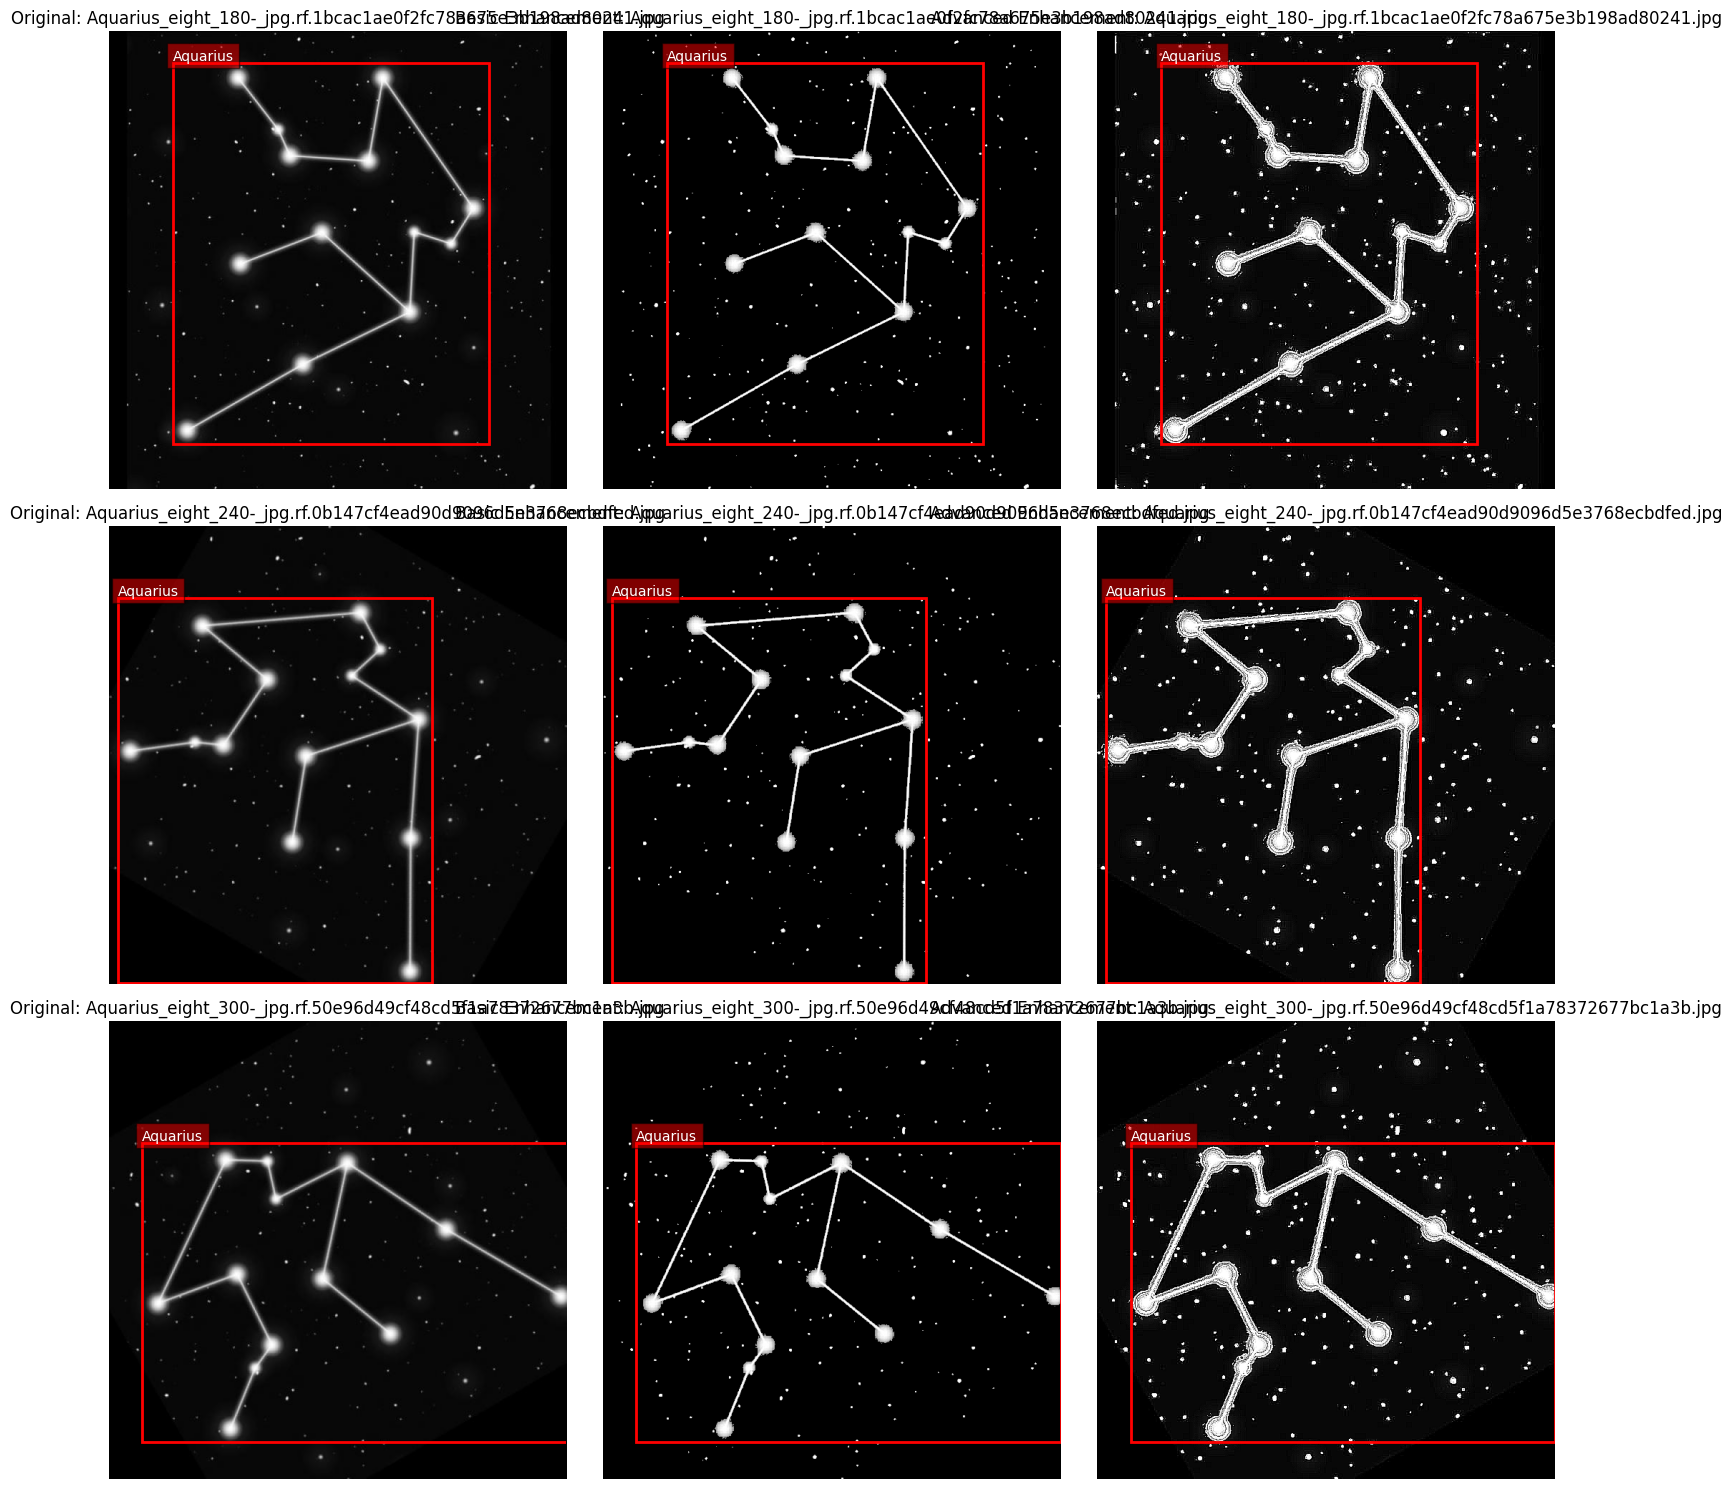

In [36]:
# Compare different enhancement techniques
try:
    print("Comparing different image enhancement techniques:")
    visualize_enhanced_samples(DATASET_PATH)
except Exception as e:
    print(f"Error visualizing enhanced samples: {e}")

In [37]:
def create_parameter_tuning_ui(image_path):
    """Create interactive UI for tuning enhancement parameters on a sample image"""
    from ipywidgets import interact, interactive, fixed, widgets
    import ipywidgets as widgets
    from IPython.display import display
    
    # Load the image
    img = cv2.imread(image_path)
    if img is None:
        print(f"Error: Could not load image at {image_path}")
        return
    
    # Function to update image based on parameters
    def update_image(star_threshold, gamma, clahe_clip_limit, sharpness):
        # Make a copy of the original image
        enhanced = img.copy()
        
        # Convert to grayscale for processing
        gray = cv2.cvtColor(enhanced, cv2.COLOR_BGR2GRAY)
        
        # Apply bilateral filter to reduce noise while preserving edges
        gray = cv2.bilateralFilter(gray, 5, 50, 50)
        
        # Apply CLAHE (Contrast Limited Adaptive Histogram Equalization)
        clahe = cv2.createCLAHE(clipLimit=clahe_clip_limit, tileGridSize=(8, 8))
        gray = clahe.apply(gray)
        
        # Apply gamma correction
        gray = np.array(255 * (gray / 255) ** gamma, dtype=np.uint8)
        
        # Apply unsharp mask for local contrast enhancement
        gaussian = cv2.GaussianBlur(gray, (0, 0), 3.0)
        unsharp_mask = cv2.addWeighted(gray, 1.5, gaussian, -0.5, 0)
        gray = unsharp_mask
        
        # Apply morphological operations to enhance stars
        kernel = np.ones((2, 2), np.uint8)
        tophat = cv2.morphologyEx(gray, cv2.MORPH_TOPHAT, kernel)
        gray = cv2.add(gray, tophat)
        
        # Apply thresholding to isolate stars
        _, stars_mask = cv2.threshold(gray, star_threshold, 255, cv2.THRESH_TOZERO)
        
        # Create a blended output with original colors but enhanced stars
        original_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        h, s, v = cv2.split(original_hsv)
        v = cv2.bitwise_or(v, stars_mask)
        enhanced_hsv = cv2.merge([h, s, v])
        enhanced = cv2.cvtColor(enhanced_hsv, cv2.COLOR_HSV2BGR)
        
        # Apply sharpening
        kernel = np.array([[-1, -1, -1],
                           [-1, 9 + sharpness, -1],
                           [-1, -1, -1]], dtype=np.float32)
        enhanced = cv2.filter2D(enhanced, -1, kernel)
        
        # Display results
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
        ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        ax1.set_title('Original')
        ax1.axis('off')
        
        ax2.imshow(cv2.cvtColor(enhanced, cv2.COLOR_BGR2RGB))
        ax2.set_title('Enhanced')
        ax2.axis('off')
        
        plt.tight_layout()
        plt.show()
    
    # Create interactive UI
    interact(update_image, 
             star_threshold=widgets.IntSlider(min=50, max=200, step=5, value=130, description='Star Threshold:'),
             gamma=widgets.FloatSlider(min=0.1, max=1.0, step=0.05, value=0.5, description='Gamma:'),
             clahe_clip_limit=widgets.FloatSlider(min=1.0, max=5.0, step=0.5, value=3.0, description='CLAHE Clip:'),
             sharpness=widgets.FloatSlider(min=0, max=5, step=0.5, value=0, description='Extra Sharpness:'))

In [38]:
# Find a sample image to use for parameter tuning
sample_image_path = os.path.join(DATASET_PATH, "train", "images", os.listdir(os.path.join(DATASET_PATH, "train", "images"))[0])
print(f"Using sample image: {sample_image_path}")

# Create interactive UI for parameter tuning
try:
    create_parameter_tuning_ui(sample_image_path)
except Exception as e:
    print(f"Error creating parameter tuning UI: {e}")
    print("Note: You may need to install ipywidgets: pip install ipywidgets")

Using sample image: constellation_dataset\train\images\Aquarius_eight_180-_jpg.rf.1bcac1ae0f2fc78a675e3b198ad80241.jpg


interactive(children=(IntSlider(value=130, description='Star Threshold:', max=200, min=50, step=5), FloatSlide…